In [ ]:
!pip install --upgrade numba scikit-learn numpy scikit-image

In [ ]:
!pip install pandas-profiling

In [ ]:
!pip install --upgrade umap-learn

In [ ]:
!sudo apt-get install -y \
libaec-dev libblosc-dev libbrotli-dev \
libz-dev libblosc-dev liblzma-dev liblz4-dev \
libzstd-dev libpng-dev libwebp-dev libbz2-dev \
libopenjp2-7-dev libjpeg-turbo8-dev libjxr-dev \
liblcms2-dev libcharls-dev libaec-dev libbrotli-dev \
libsnappy-dev libzopfli-dev libgif-dev libtiff-dev

In [ ]:
!pip install --upgrade pandas matplotlib datashader bokeh holoviews colorcet

- get clean (!) data
- select features, filter accordingly (e. g. nans)
  - + sampling (?)
  - + outlier detection !!!
- standardscaler
- dimension reduction
- plotting with different labels
- clustering
  - investigate clusters

In [1]:
import io

import pandas as pd
import numpy as np
import requests

import umap
import umap.plot

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS, DBSCAN

/home/borza/.my_venv/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [172]:
from pandas_profiling import ProfileReport

In [2]:
resp = requests.get("http://rajk.uni-corvinus.hu/hasznaltauto.csv", verify=False)

/home/borza/.my_venv/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rajk.uni-corvinus.hu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [3]:
df = pd.read_csv(io.BytesIO(resp.content))

In [6]:
df.shape

(102295, 97)

In [5]:
rel_cols = ["parsed_price", "horsepower", "cc", "kms", "year"]

In [7]:
df.dropna(subset=rel_cols).shape

(86189, 97)

In [116]:
FR = ["renault", "peugeot", "citroen"]
JP = ["toyota", "suzuki", "mazda", "nissan", "honda", "hyundai", "mitsubishi", "lexus"]

In [13]:
type(lambda _df: _df["brand"].isin(_df["brand"].value_counts().index[:2]))

function

In [ ]:
df_filt = (
    df.dropna(subset=rel_cols)
      .loc[lambda _df: _df["brand"].isin(_df["brand"].value_counts().index[:2]), :]
      .loc[lambda _df: (_df["cc"] < 5000) & (_df["horsepower"] < 1000)]
)

In [125]:
df_filt = (
    df.dropna(subset=rel_cols)
      .loc[lambda df: ~df[rel_cols].apply(lambda s: (s.quantile(0.99) * 4) < s).any(axis=1), :]
      .loc[lambda _df: _df["brand"].isin(FR + JP), :]
)

In [173]:
report = ProfileReport(df_filt)

In [175]:
html_str = report.to_html()

In [176]:
with open("report.html", "w") as fp:
    fp.write(html_str)

In [126]:
df_filt.shape

(25378, 97)

In [127]:
df_filt.isna().mean().loc[lambda s: (s > 0.3) & (s < 0.8)]

ALUFELNI          0.479076
ASR               0.569509
BLUETOOTH         0.742927
ESP               0.509299
FŰTHETŐ TÜKÖR     0.495390
ISOFIX            0.567854
KÖDLÁMPA          0.520254
LÉGZSÁK           0.368863
PÓTKERÉK          0.726377
SZÍNEZETT ÜVEG    0.765387
dtype: float64

In [128]:
df_for_mapper = df_filt.loc[:, rel_cols].pipe(StandardScaler().fit_transform)

In [129]:
%%time
mapper = umap.UMAP(n_neighbors=100, n_components=2, set_op_mix_ratio=1.0).fit(
    df_for_mapper
)

CPU times: user 2min 36s, sys: 7.61 s, total: 2min 44s
Wall time: 3min 49s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


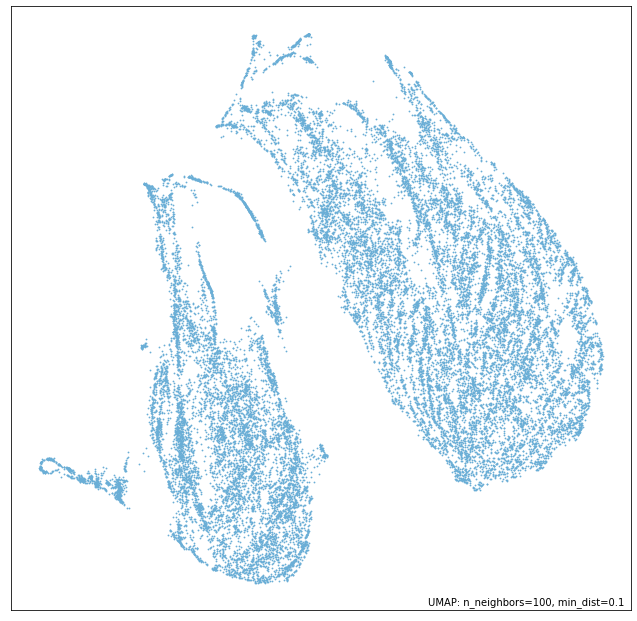

In [130]:
umap.plot.points(mapper)

In [131]:
def get_cuts(s):
    return pd.qcut(s, 5).apply(lambda s: s.mid).astype(float)

In [153]:
labels = df_filt["parsed_price"].pipe(get_cuts)
labels = df_filt["horsepower"].pipe(get_cuts)
#labels = df_filt["cc"].pipe(get_cuts)
labels = df_filt["kms"].pipe(get_cuts)
labels = df_filt["year"].pipe(get_cuts)

In [132]:
labels = df_filt["brand"]

In [134]:
labels = df_filt["brand"].isin(FR)

In [169]:
labels = df_filt["cc"] > 1600

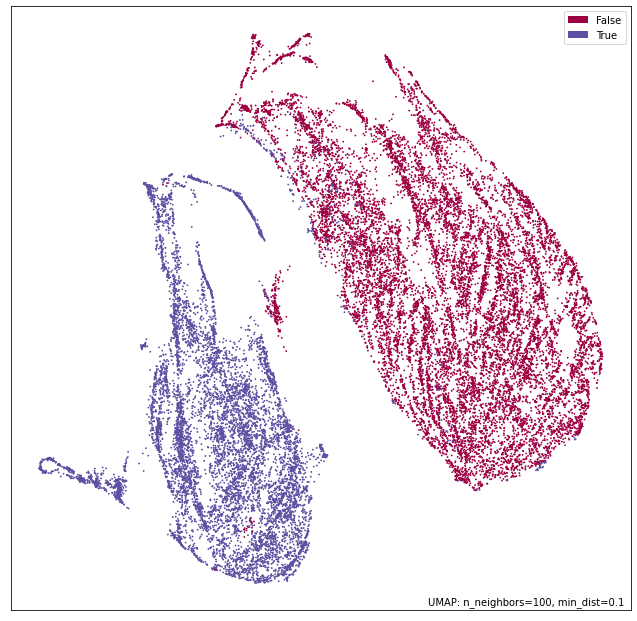

In [170]:
umap.plot.points(mapper, labels=labels)

In [87]:
mapped_points = mapper.transform(df_for_mapper)

In [95]:
df_filt.loc[:, rel_cols].assign(x=mapped_points[:, 0], y=mapped_points[:, 1]).corr()

,parsed_price,horsepower,cc,kms,year,x,y
parsed_price,1.000000,0.575673,0.269546,-0.171073,0.659228,-0.290204,-0.114075
horsepower,0.575673,1.000000,0.718212,-0.035717,0.425358,-0.700360,-0.240598
cc,0.269546,0.718212,1.000000,0.082288,0.036298,-0.697086,-0.391292
kms,-0.171073,-0.035717,0.082288,1.000000,-0.175939,-0.053568,-0.060843
year,0.659228,0.425358,0.036298,-0.175939,1.000000,-0.176562,0.210508
x,-0.290204,-0.700360,-0.697086,-0.053568,-0.176562,1.000000,0.097742
y,-0.114075,-0.240598,-0.391292,-0.060843,0.210508,0.097742,1.000000


In [151]:
labels = df_filt["fuel"].fillna("NA").pipe(
    lambda s: np.where(s.isin(s.value_counts().index[:3]), s, "other")
)

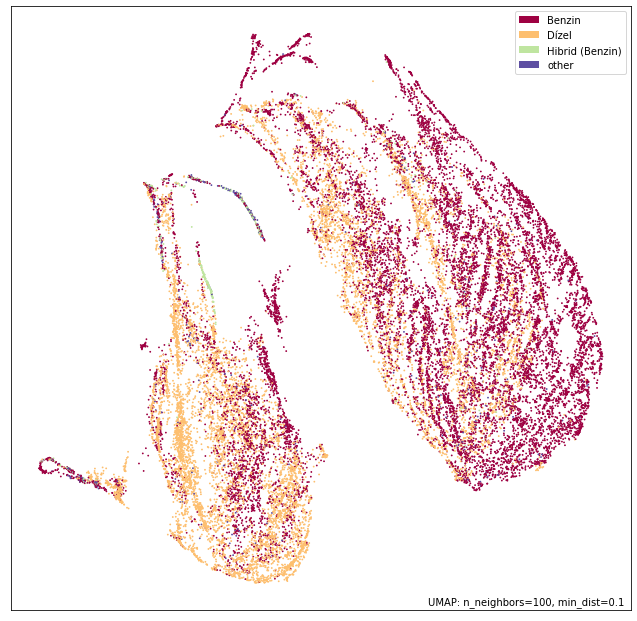

In [152]:
umap.plot.points(mapper, labels=labels)

In [155]:
labels = df_filt.loc[:, "LÉGZSÁK"].fillna(0)

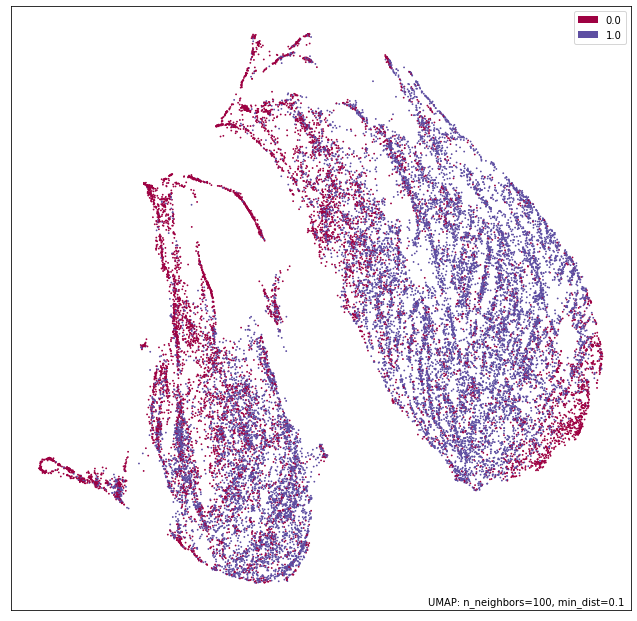

In [156]:
umap.plot.points(mapper, labels=labels)

some [clustering](https://scikit-learn.org/stable/modules/clustering.html)

In [160]:
labels = DBSCAN(eps=1).fit_predict(mapper.transform(df_for_mapper))

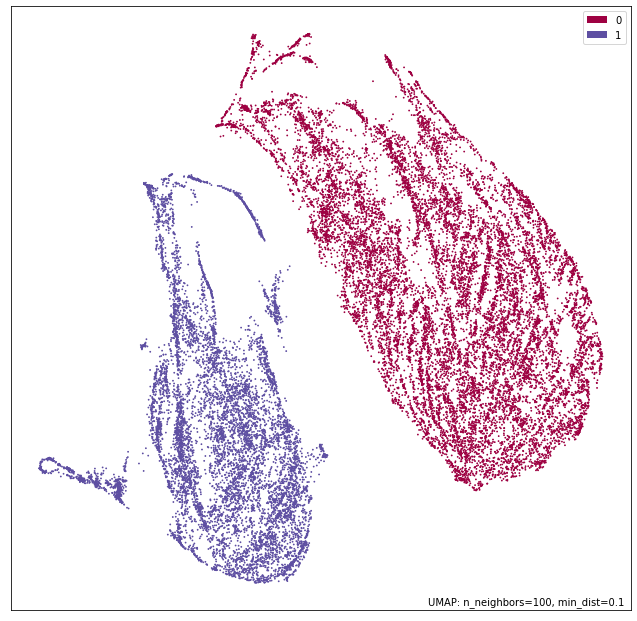

In [145]:
umap.plot.points(mapper, labels=labels)

In [149]:
df_filt.dropna(axis=1).groupby(labels).agg(["mean", "std"])

parsed_price                horsepower                      cc              \
           mean           std        mean        std         mean         std   
0  1.699417e+06  1.505726e+06   94.413596  21.339375  1404.797078  185.507357   
1  2.800111e+06  3.608117e+06  145.580084  49.276283  2140.524102  461.982596   

             kms                       year            
            mean           std         mean       std  
0  148724.771961  77076.113347  2007.508618  5.960110  
1  189980.015659  91025.072423  2007.435268  5.162476

In [168]:
df_filt.assign(model=lambda df: df["brand"] + "-" + df["link"].str.split("/").str[5]).loc[labels == 1, :].loc[lambda df: df["model"] == "suzuki-swift", rel_cols]

,parsed_price,horsepower,cc,kms,year
7863,220000.0,68.0,1298.0,1450000.0,1998.0


In [165]:
(
    df_filt.assign(model=lambda df: df["brand"] + "-" + df["link"].str.split("/").str[5])
    .loc[:, "model"]
    .groupby(labels)
    .apply(lambda s: s.value_counts())
    .reset_index()
    .pivot_table(columns="level_0", index="level_1", values="model")
    .assign(summa=lambda df: df.sum(axis=1))
    .sort_values("summa", ascending=False)
    #.pipe(lambda s: (s.T / s.T.sum()).T)
    .dropna()
    .head(20)
)

level_0,0,1,summa
level_1,,,
renault-megane,941.0,196.0,1137.0
suzuki-swift,1128.0,1.0,1129.0
mazda-6,3.0,768.0,771.0
honda-civic,500.0,247.0,747.0
toyota-avensis,71.0,583.0,654.0
renault-clio,603.0,20.0,623.0
toyota-yaris,579.0,8.0,587.0
hyundai-i30,537.0,8.0,545.0
renault-scenic,364.0,173.0,537.0


In [150]:
df_filt.fillna(0).assign(label=labels).corr()[
    "label"
].dropna().sort_values().to_frame().pipe(
    lambda df: pd.concat([df.head(10), df.tail(10)])
)

,label
LÉGZSÁK,-0.189960
PÓTKERÉK,-0.151773
SZÍNEZETT ÜVEG,-0.146839
AZONNAL ELVIHETŐ,-0.140373
AUTÓBESZÁMÍTÁS LEHETSÉGES,-0.130941
KEVESET FUTOTT,-0.098262
USB,-0.089521
HÖLGY TULAJDONOSTÓL,-0.089469
GARÁZSBAN TARTOTT,-0.086420
RÁDIÓS MAGNÓ,-0.084495
